In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/iREC


### Import Modules

In [41]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
from tqdm import tqdm
from models.BayesianLinRegressor import BayesLinRegressor
from rec.utils import kl_estimate_with_mc, plot_running_sum_1d, plot_running_sum_2d, \
plot_2d_distribution, plot_1d_distribution, compute_variational_posterior
from rec.Coders.Encoder_Parallel import Encoder as Empirical_Encoder
from rec.Coders.Encoder_Gaussian_Target import Encoder as Variational_Encoder
from rec.distributions.EmpiricalMixturePosterior_Parallel import EmpiricalMixturePosterior
from rec.distributions.VariationalPosterior import VariationalPosterior
from rec.samplers.GreedySampling import GreedySampler
from rec.samplers.ImportanceSampling import ImportanceSampler
from rec.distributions.CodingSampler import CodingSampler as coding_sampler

In [42]:
def create_lin_reg_problem(dim=2, alpha=0.01, signal_std=5, num_points=10, seed=0):
    """
    Creates a linear regression problem by sampling from a Bayesian Linear Regression Prior.
    After observing points, computes Bayesian Posterior.
    Returns target distribution.
    """
    
    # get Bayesian Linear Regression Object
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                            prior_alpha=alpha,
                            signal_std=signal_std,
                            num_targets=num_points,
                            seed=seed)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    
    return target

In [83]:
def encode_sample(target, posterior_method='empirical_distribution', omega=8, epsilon=0.,
                  n_samples=10, sampling_method='Greedy', seed=0):
    
    if posterior_method == 'empirical_distribution':
        if sampling_method == 'Greedy':
            selection_sampler = GreedySampler
        else:
            selection_sampler = ImportanceSampler

        encoder = Empirical_Encoder(target,
                                    seed,
                                    coding_sampler,
                                    selection_sampler,
                                    EmpiricalMixturePosterior,
                                    omega,
                                    n_samples,
                                    epsilon=epsilon,
                                    )
    else:
        if sampling_method == 'Greedy':
            selection_sampler = GreedySampler
        else:
            selection_sampler = ImportanceSampler
        dim = target.mean.shape[0]
        if dim > 1:
            target = compute_variational_posterior(target)
        encoder = Variational_Encoder(target,
                                      seed,
                                      coding_sampler,
                                      selection_sampler,
                                      VariationalPosterior,
                                      omega,
                                      epsilon=epsilon,
                                      )
    
    return encoder, *encoder.run_encoder()

In [125]:
def run_and_plot_coded_sample(dim=2, alpha=0.01, signal_std=5, num_points=10, num_samples=10,
                              posterior_method='empirical_distribution', omega=8, epsilon=0.,
                              sampling_method='Greedy', seed=0):

    # create problem
    target = create_lin_reg_problem(dim=dim, alpha=alpha, signal_std=signal_std, num_points=num_points, seed=seed)
    encoder, z, indices = encode_sample(target, posterior_method=posterior_method, omega=omega, epsilon=epsilon,
                                        n_samples=num_samples, sampling_method=sampling_method, seed=seed)
    
    
    # plot things for 1 and 2 dimensions
    if dim == 2:
        plt.figure(figsize=(10,10))
        plot_2d_distribution(target)
        plot_running_sum_2d(encoder.selected_samples, plot_index_labels=False)
#         plt.plot(encoder.auxiliary_posterior.empirical_samples[:, 0], encoder.auxiliary_posterior.empirical_samples[:, 1],
#              'x')
        plt.plot(z[0], z[1], 'o')
    elif dim == 1:
        plot_1d_distribution(target)
        plot_running_sum_1d(target, encoder.selected_samples, plot_index_labels=False)
        plt.plot(z, torch.exp(target.log_prob(z)), 'o')
    
    print(target.log_prob(z))

# Easy 1d example

## Empirical Method

  0%|          | 0/5 [00:00<?, ?it/s]

tensor(-1.3786)


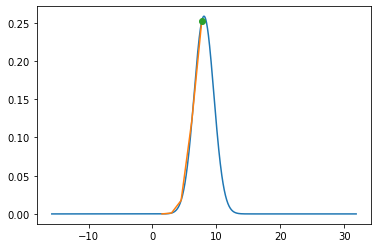

In [126]:
run_and_plot_coded_sample(dim=1, alpha=0.02, omega=8, num_samples=5)

## Variational Posterior Method

### In this case the Variational Posterior is identical to true posterior

32.74700164794922


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(-1.3530)


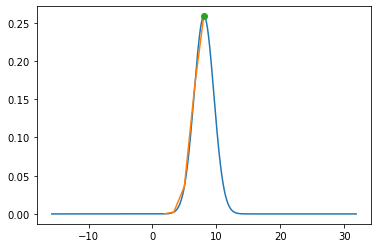

In [127]:
run_and_plot_coded_sample(dim=1, alpha=0.02, omega=8, posterior_method='Variational')

# Hard 1d Example

## Empirical Method

In [ ]:
run_and_plot_coded_sample(dim=1, alpha=0.001, omega=8, num_samples=1000, epsilon=0.)

  0%|          | 0/134 [00:00<?, ?it/s]

## Variational Posterior Method

### In this case the Variational Posterior is identical to true posterior

In [ ]:
run_and_plot_coded_sample(dim=1, alpha=0.001, omega=8, posterior_method='Variational', epsilon=0.)

# Easy 2d Example

## Empirical Method

In [ ]:
run_and_plot_coded_sample(dim=2, alpha=0.007, omega=8, num_samples=500)

## Variational Posterior Method

### In this case the Variational Posterior is identical to true posterior

In [ ]:
run_and_plot_coded_sample(dim=2, alpha=0.007, omega=8, posterior_method='Variational')

# Hard 1d Example

## Empirical Method

In [ ]:
run_and_plot_coded_sample(dim=2, alpha=0.0001, omega=8, num_samples=100, epsilon=0.)

## Variational Posterior Method

### In this case the Variational Posterior is identical to true posterior

In [ ]:
run_and_plot_coded_sample(dim=2, alpha=0.0001, omega=8, posterior_method='Variational', epsilon=0.)